In [38]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import pandas as pd


## Zadanie 1 - TSP

### Generowanie chmur punktów

In [39]:
def point_cloud_uniform(n, low, high):
    uniform_points = []
    pts = np.random.uniform(low, high, size=(n,2))
    uniform_points.extend(pts)
    return uniform_points

In [40]:
def point_cloud_normal(n, normal_params):
    normal_points = []
    for mx, my, std in normal_params:
        pts = np.random.normal((mx,my), std, size = (n,2))
        normal_points.extend(pts)
    return normal_points

In [41]:
def point_cloud_clusters(n, low_cntr, high_cntr):
    grid_centers = [(x, y) for x in [low_cntr, (low_cntr+high_cntr)/2, high_cntr] for y in [low_cntr, (low_cntr+high_cntr)/2, high_cntr]]
    cluster_points = []
    for cx, cy in grid_centers:
        x = np.random.normal(cx, abs(low_cntr-high_cntr)/15, n)
        y = np.random.normal(cy, abs(low_cntr-high_cntr)/15, n)
        cluster_points.extend(np.column_stack((x, y)))
    return cluster_points

### Funkcja kosztu dla TSP
Odległość między kolejnymi punktami według metryki euklidesowej

In [42]:
def tsp_loss(s):
    dist = 0
    for i in range(len(s)):
        dist += np.linalg.norm(s[i] - s[i-1])
    return dist

### Zamiana elementów

In [43]:
def tsp_arbitrary_swap(s):
    a = rn.randint(0, len(s)-1)
    b = rn.randint(0, len(s)-1)
    new_s = s.copy()
    a_x, a_y = new_s[a]
    b_x, b_y = new_s[b]
    new_s[a], new_s[b] = np.array([b_x, b_y]), np.array([a_x, a_y])
    return new_s

In [44]:
def tsp_consecutive_swap(s):
    a = rn.randint(0, len(s)-1)
    b = a-1
    new_s = s.copy()
    a_x, a_y = new_s[a]
    b_x, b_y = new_s[b]
    new_s[a], new_s[b] = np.array([b_x, b_y]), np.array([a_x, a_y])
    return new_s

### Funkcje schładzania - eksponencjalna i liniowa

In [45]:
def tsp_temp_exp(T, alfa, k):
    return T*alfa

In [46]:
def tsp_temp_lin(T, alfa, k):
    return T - alfa

### Prawdopodobieństwo zaakceptowania gorszego wyniku
$e^{-(n_v - c_v)/T}$

In [47]:
def probability_of_acceptance(T, c_v, n_v):
    return np.exp(-abs(n_v - c_v)/T)

## Implementacja algorytmu symulowanego wyrzażania
Algorytm został napisany w sposób umożliwiający minimalizację dowolnej funkcji

Przyjmowane argumenty:

s - początkowy stan (w naszym przypadku jest to tablica z losową kolejnością w której odwiedzamy punkty lub losowo wypełniona tablica sudoku w zadaniu 3)

T - początkowa temperatura

alfa - hiperparametr wykorzystywany funkcji chłodzenia

eps - dodatkowy warunek stopu (kiedy temperatura osiagnie wartość mniejszą niż eps)

swap_func - funkcja zmiany stanu

change_temp_func - funkcja schładzania

loss_func - minimalizowana funkcja kosztu

probability_of_acceptance - funkcja prawdopodobieństwa przyjęcia gorszego wyniku

In [48]:
def sim_annealing(s, max_iters, T, alfa, eps, swap_func, change_temp_func, loss_func, probability_of_acceptance_func=probability_of_acceptance):
    best = float('inf')
    best_result = None
    vals = []
    
    for k in range(max_iters):
        T = change_temp_func(T, alfa, k)
        if T < eps:
            break

        curr_val = loss_func(s)
        vals.append(curr_val)
        
        new_s = swap_func(s)
        new_val = loss_func(new_s)
        
        if new_val < curr_val or rn.uniform(0, 1) <= probability_of_acceptance_func(T, curr_val, new_val):
            s = new_s
            if new_val < best:
                best = new_val
                best_result = new_s.copy()

    return best, vals, best_result

### Rysowanie wykresów oraz znalezionej ścieżki

In [49]:
def draw_plot(vals, ax=None, title=""):
    x = [i for i in range(len(vals))]
    if ax is None:
        plt.figure(figsize=(10, 5))
        plt.plot(x, vals)
        plt.title('Simulated annealing ' + title)
        plt.xlabel('Iteration')
        plt.ylabel('Current value')
        plt.grid(True)
        plt.show()
    else:
        ax.plot(x, vals)
        ax.set_title(title)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Current value')
        ax.grid(True)


In [50]:
def draw_path(points, ax, title=""):
    x = np.hstack((points[:, 0], points[0,0]))
    y = np.hstack((points[:, 1], points[0,1]))
    ax.plot(x, y, marker='o')
    ax.set_title(title)

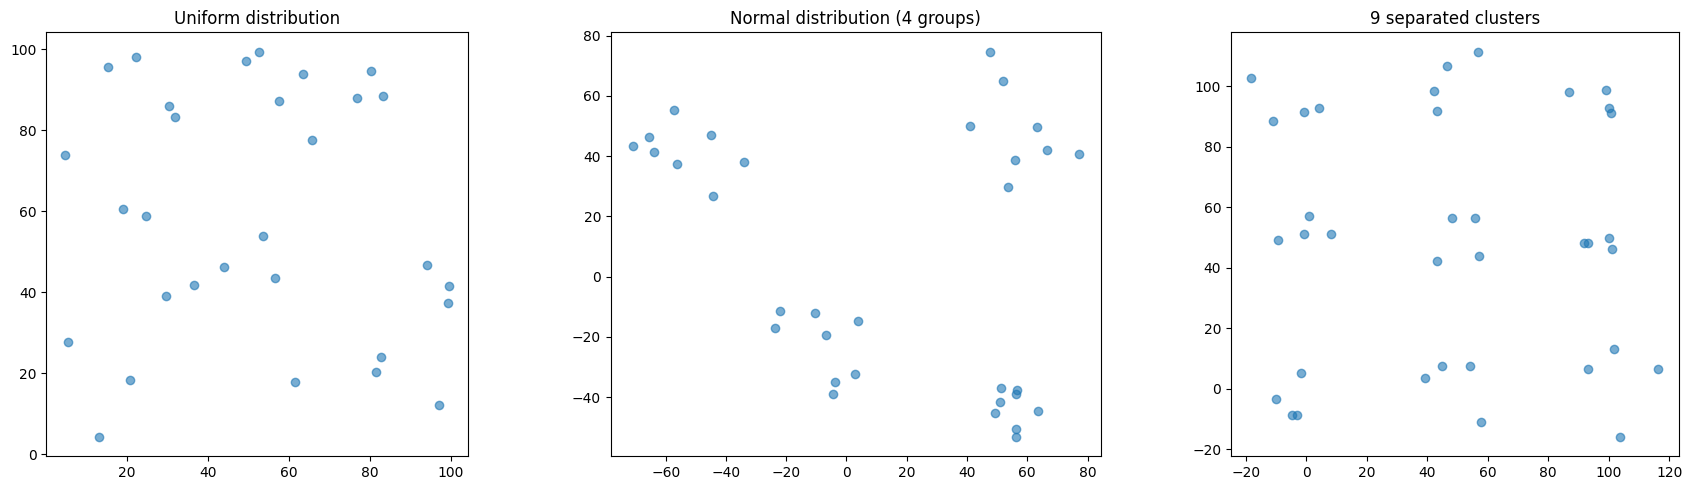

In [15]:
params = [
(-10, -20, 10),     # (mean_x, mean_y, std)
(50, 50, 12),
(-50, 50, 11),
(50, -50, 8)
]
uniform_point_cloud = point_cloud_uniform(30, 0, 100)  # 50 points
normal_point_cloud = point_cloud_normal(8, params)  # 8 points per group - 32 in total
cluster_point_cloud = point_cloud_clusters(4, 0, 100)  # 4 points per cluster - 36 in total

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Rozkład jednostajny
axs[0].scatter(np.array(uniform_point_cloud)[:,0], np.array(uniform_point_cloud)[:,1], alpha=0.6)
axs[0].set_title('Uniform distribution')
axs[0].set_aspect('equal')

# Rozkład normalny (4 grupy)
axs[1].scatter(np.array(normal_point_cloud)[:,0], np.array(normal_point_cloud)[:,1], alpha=0.6)
axs[1].set_title('Normal distribution (4 groups)')
axs[1].set_aspect('equal')

# 9 odseparowanych grup
axs[2].scatter(np.array(cluster_point_cloud)[:,0], np.array(cluster_point_cloud)[:,1], alpha=0.6)
axs[2].set_title('9 separated clusters')
axs[2].set_aspect('equal')

plt.tight_layout()
plt.show()

Wygenerowane chmury punktów przy odpowiednich założeniach (z rozkładem jednostajnym, w 4 grupach z rozkładem normalnym oraz w 9 grupach z rozkładem jednostajnym)

In [105]:
res_uniform, values_uniform, last_uniform = sim_annealing(np.random.permutation(uniform_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_arbitrary_swap, tsp_temp_exp, tsp_loss)

In [109]:
res_uniform, values_uniform, last_uniform = sim_annealing(np.random.permutation(uniform_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_arbitrary_swap, tsp_temp_exp, tsp_loss)
res_normal, values_normal, last_normal = sim_annealing(np.random.permutation(normal_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_arbitrary_swap, tsp_temp_exp, tsp_loss)
res_cluster, values_cluster, last_cluster = sim_annealing(np.random.permutation(cluster_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_arbitrary_swap, tsp_temp_exp, tsp_loss)

res_uniform_con, values_uniform_con, last_uniform_con = sim_annealing(np.random.permutation(uniform_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_consecutive_swap, tsp_temp_exp, tsp_loss)
res_normal_con, values_normal_con, last_normal_con = sim_annealing(np.random.permutation(normal_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_consecutive_swap, tsp_temp_exp, tsp_loss)
res_cluster_con, values_cluster_con, last_cluster_con = sim_annealing(np.random.permutation(cluster_point_cloud.copy()), 75000, 500, 0.99991, 0.001, tsp_consecutive_swap, tsp_temp_exp, tsp_loss)

res_uniform_temp, values_uniform_temp, last_uniform_temp = sim_annealing(np.random.permutation(uniform_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_arbitrary_swap, tsp_temp_lin, tsp_loss)
res_normal_temp, values_normal_temp, last_normal_temp = sim_annealing(np.random.permutation(normal_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_arbitrary_swap, tsp_temp_lin, tsp_loss)
res_cluster_temp, values_cluster_temp, last_cluster_temp = sim_annealing(np.random.permutation(cluster_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_arbitrary_swap, tsp_temp_lin, tsp_loss)

res_uniform_t_c, values_uniform_t_c, last_uniform_t_c = sim_annealing(np.random.permutation(uniform_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_consecutive_swap, tsp_temp_lin, tsp_loss)
res_normal_t_c, values_normal_t_c, last_normal_t_c = sim_annealing(np.random.permutation(normal_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_consecutive_swap, tsp_temp_lin, tsp_loss)
res_cluster_t_c, values_cluster_t_c, last_cluster_t_c = sim_annealing(np.random.permutation(cluster_point_cloud.copy()), 75000, 100, 0.0014, 0.001, tsp_consecutive_swap, tsp_temp_lin, tsp_loss)

Wywołania składają się z 4 wersji:
- z wykorzystaniem eksponencjalnej funkcji schładzania oraz zamieniając miejscami losowe punkty
- z wykorzystaniem eksponencjalnej funkcji schładzania oraz zamieniając miejscami jedynie sąsiadujące punkty
- z wykorzystaniem liniowej funkcji schładzania oraz zamieniajac miejscami losowe punkty
- z wykorzsytaniem liniowej funkcji schładzania oraz zamieniając miejscami jedynie sąsiadujace punkty

Wszystkie wersje zostały wywołane dla każdej z chmur punktów

---
### Długości znalezionych najkrótszych tras

In [110]:
data = {
    'Uniform dist': [res_uniform, res_uniform_con, res_uniform_temp, res_uniform_t_c],
    'Normal dist': [res_normal, res_normal_con, res_normal_temp, res_normal_t_c],
    '9 Clusters': [res_cluster, res_cluster_con, res_cluster_temp, res_cluster_t_c]
}

index = ['Arbitrary swaps & exponential temp', 'Consecutive_swaps & exponential temp', 'Arbitrary swaps & linear temp', 'Consecutive_swaps & linear temp']
df = pd.DataFrame(data, index=index)
print(df)

                                      Uniform dist  Normal dist   9 Clusters
Arbitrary swaps & exponential temp      463.647801   535.840635   659.713559
Consecutive_swaps & exponential temp    881.383971  1102.661008  1316.167237
Arbitrary swaps & linear temp           463.647801   605.735392   655.981771
Consecutive_swaps & linear temp         697.411009  1012.216472  1172.552742


### Porównanie zmian energii dla wszystkich wersji (przy 75000 iteracji)
Możemy na wykresach wyodrębnić początkową część - losowe poszukiwanie, która stopniowo się zwęża wraz ze spadkiem temperatury i przechodzi w spadek wzdłuż gradientu

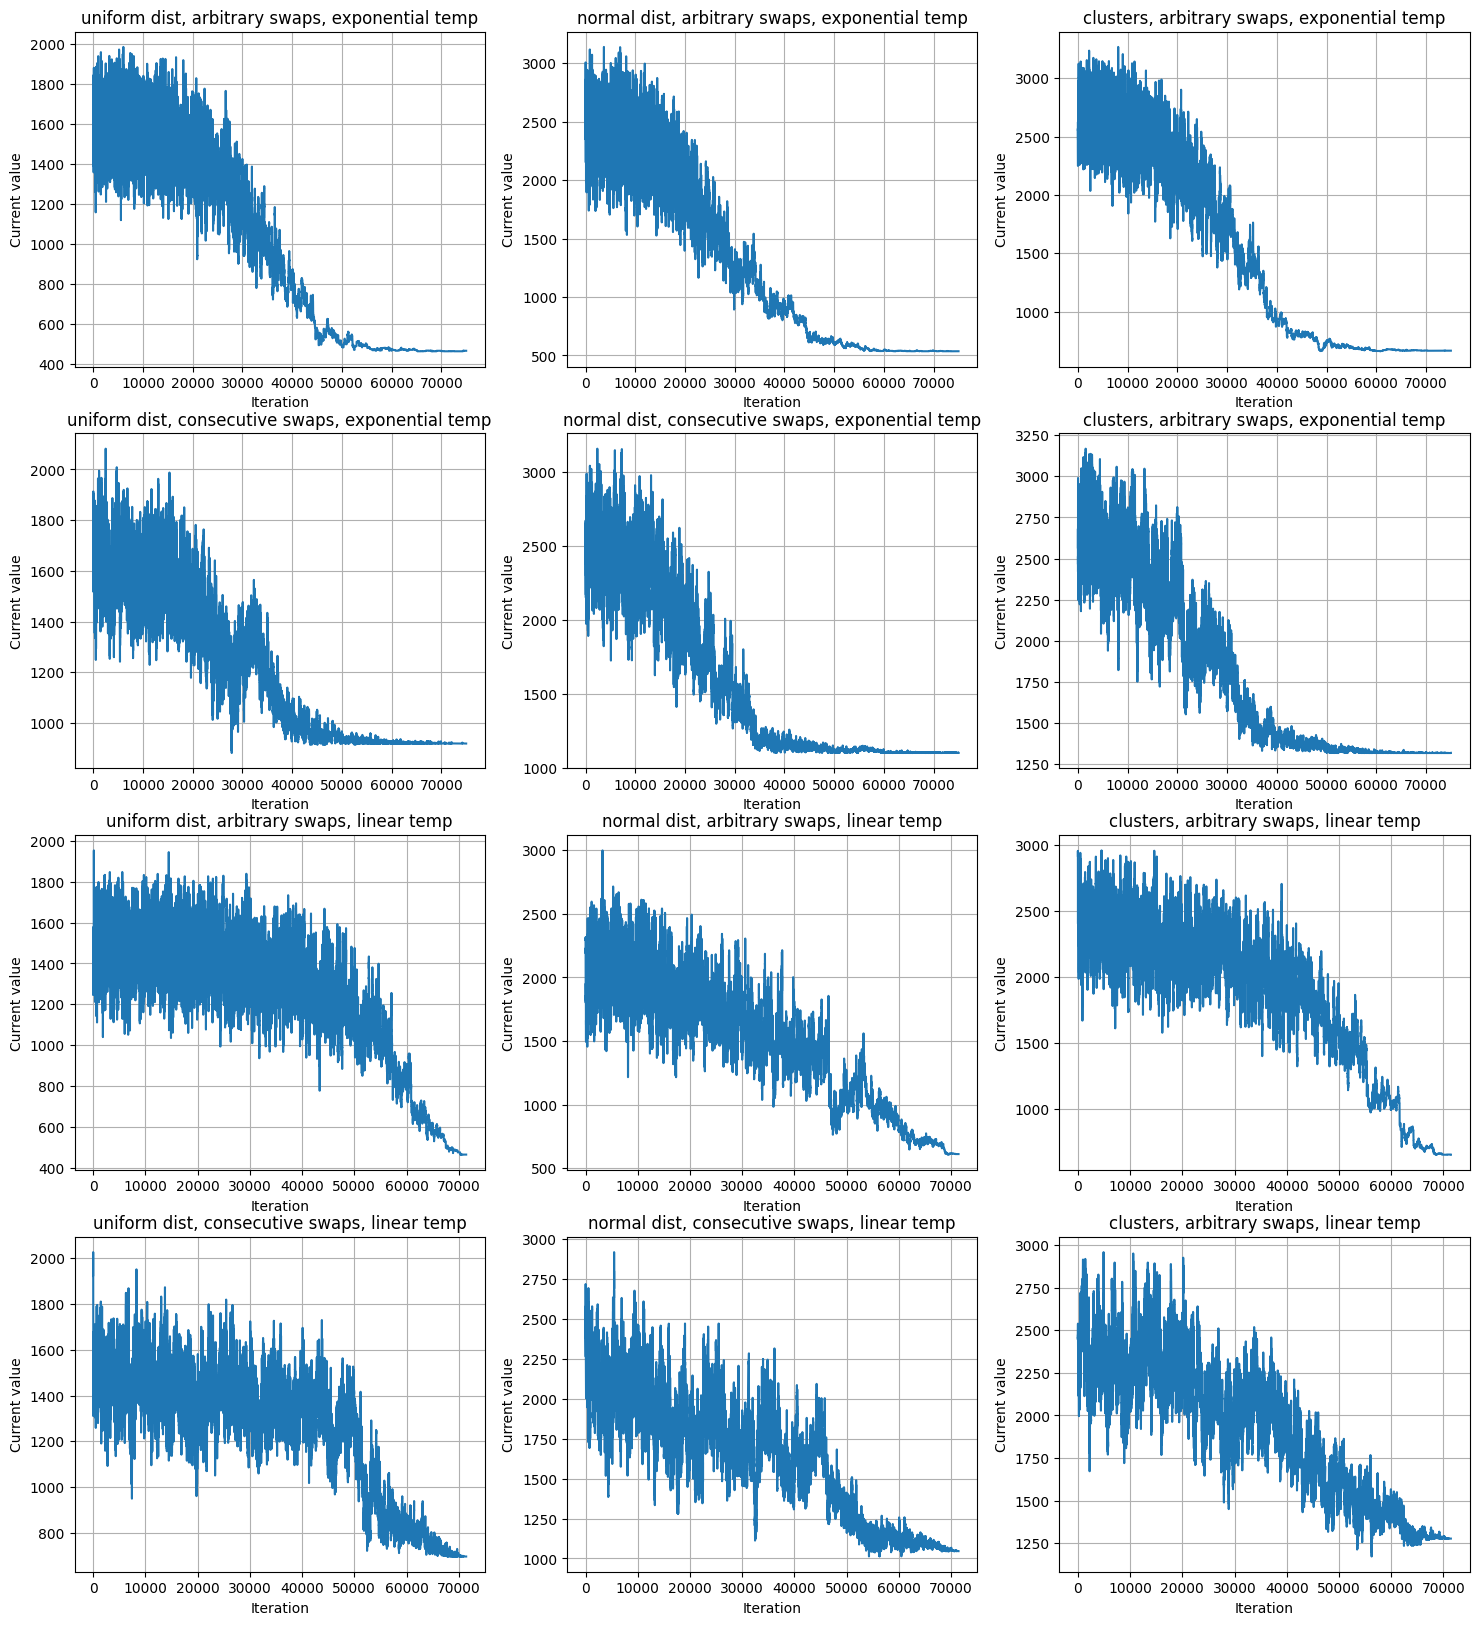

In [111]:
_, ax = plt.subplots(4, 3, figsize=(18, 20))
draw_plot(values_uniform, ax[0, 0], "uniform dist, arbitrary swaps, exponential temp")
draw_plot(values_normal, ax[0, 1], "normal dist, arbitrary swaps, exponential temp")
draw_plot(values_cluster, ax[0, 2], "clusters, arbitrary swaps, exponential temp")
draw_plot(values_uniform_con, ax[1, 0], "uniform dist, consecutive swaps, exponential temp")
draw_plot(values_normal_con, ax[1, 1], "normal dist, consecutive swaps, exponential temp")
draw_plot(values_cluster_con, ax[1, 2], "clusters, arbitrary swaps, exponential temp")
draw_plot(values_uniform_temp, ax[2, 0], "uniform dist, arbitrary swaps, linear temp")
draw_plot(values_normal_temp, ax[2, 1], "normal dist, arbitrary swaps, linear temp")
draw_plot(values_cluster_temp, ax[2, 2], "clusters, arbitrary swaps, linear temp")
draw_plot(values_uniform_t_c, ax[3, 0], "uniform dist, consecutive swaps, linear temp")
draw_plot(values_normal_t_c, ax[3, 1], "normal dist, consecutive swaps, linear temp")
draw_plot(values_cluster_t_c, ax[3, 2], "clusters, arbitrary swaps, linear temp")


### Wizualizacja znalezionych rozwiązań

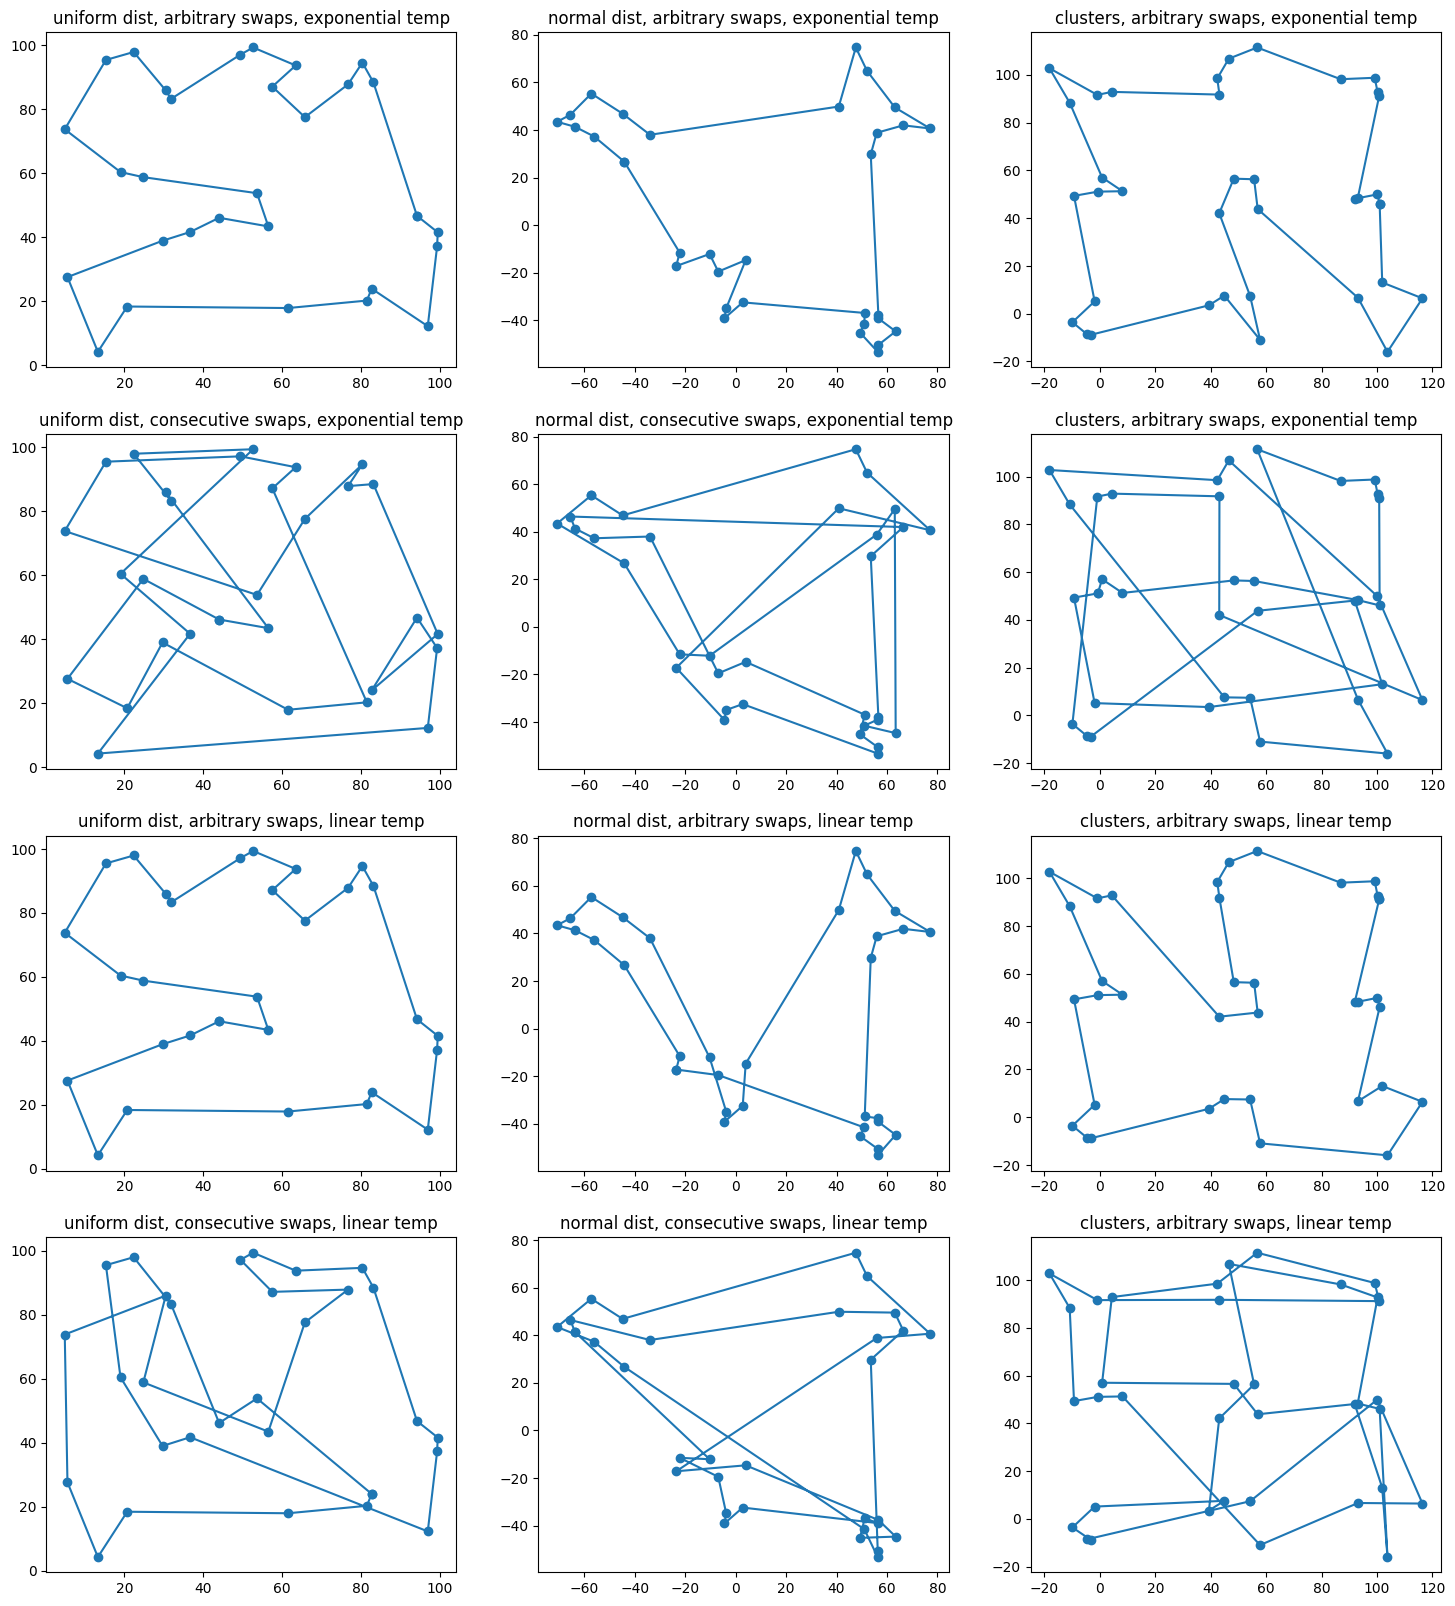

In [112]:
_, ax = plt.subplots(4, 3, figsize=(18, 20))
draw_path(last_uniform, ax[0, 0], "uniform dist, arbitrary swaps, exponential temp")
draw_path(last_normal, ax[0, 1], "normal dist, arbitrary swaps, exponential temp")
draw_path(last_cluster, ax[0, 2], "clusters, arbitrary swaps, exponential temp")
draw_path(last_uniform_con, ax[1, 0], "uniform dist, consecutive swaps, exponential temp")
draw_path(last_normal_con, ax[1, 1], "normal dist, consecutive swaps, exponential temp")
draw_path(last_cluster_con, ax[1, 2], "clusters, arbitrary swaps, exponential temp")
draw_path(last_uniform_temp, ax[2, 0], "uniform dist, arbitrary swaps, linear temp")
draw_path(last_normal_temp, ax[2, 1], "normal dist, arbitrary swaps, linear temp")
draw_path(last_cluster_temp, ax[2, 2], "clusters, arbitrary swaps, linear temp")
draw_path(last_uniform_t_c, ax[3, 0], "uniform dist, consecutive swaps, linear temp")
draw_path(last_normal_t_c, ax[3, 1], "normal dist, consecutive swaps, linear temp")
draw_path(last_cluster_t_c, ax[3, 2], "clusters, arbitrary swaps, linear temp")

Podsumowujac, zarówno dla liniowej jak i eksponencjalnej funkcji temperatury, algorytm radzi sobie dobrze, natomiast zamienianie jedynie sąsiadujacych elementów znacznie pogarsza naszą szansę na 'wpadnięcie' do globalnego minimum

## Zadanie 3 - sudoku


In [114]:
def read_board(filename):
    board = []
    with open(filename, 'r') as file:
        for row in file:
            board_row = []
            for val in row.strip():
                if val == 'x':
                    board_row.append(0)
                else:
                    board_row.append(int(val))
            board.append(board_row)
    return board

### Funkcją kosztu w sudoku
Jest to liczba duplikatów w rzędach i kolumnach. Nie sprawdzamy duplikatów w kwadratach 3x3, czego uzasadnienie znajduje się poniżej.

In [115]:
def sudoku_loss(s):
    total = 0
    for i in range(9):
        row = s[i, :]
        col = s[:, i]
        total += 9 - len(set(row))
        total += 9 - len(set(col))
    return total

### Zamiana liczb w sudoku
Losujemy kwadrat 3x3 i zamieniamy w nim dwie liczby, które nie zostały dane na początku

In [116]:
def sudoku_swap_in_square(s):
    new_sudoku = s.copy()
    box_row = np.random.randint(0, 3) * 3
    box_col = np.random.randint(0, 3) * 3

    free_cells = [(i, j) for i in range(3) for j in range(3)
                  if initial_sudoku[box_row + i, box_col + j] == 0]

    if len(free_cells) < 2:
        return new_sudoku

    (x1, y1), (x2, y2) = rn.sample(free_cells, 2)

    new_sudoku[box_row + x1, box_col + y1], new_sudoku[box_row + x2, box_col + y2] = \
        new_sudoku[box_row + x2, box_col + y2].copy(), new_sudoku[box_row + x1, box_col + y1].copy()

    return new_sudoku

### Różne funkcje zmiany temperatury

In [117]:
def sudoku_temp_change_log(T, alfa, k):
    return (np.log(k+2) * T) / np.log(k + 3)

In [118]:
def sudoku_temp_change_exp(T, alfa, k):
    return T * alfa

In [119]:
def sudoku_temp_change_lin(T, alfa, k):
    return T - alfa

In [120]:
def sudoku_probability_of_acc(T, c_v, n_v):
    return T

### Początkowe wypełnienie sudoku
Zaczynamy od wypełnienia sudoku losowymi liczbami, lecz zachowując warunek, że w żadnym kwadracie 3x3 nie może być duplikatów. Dzięki temu oraz funkcji która zamienia dwie losowe liczby jedynie w obrębie kwadratu 3x3, możemy zapewnić że warunek ten pozostanie cały czas spełniony i nie musimy uwzględniać go w funkcji kosztu.

In [121]:
def sudoku_first_fill(sudoku_array):
    filled_sudoku = sudoku_array.copy()

    for box_row in range(0, 9, 3):
        for box_col in range(0, 9, 3):
            box = filled_sudoku[box_row:box_row + 3, box_col:box_col + 3]
            existing = set(box[box > 0].flatten())
            missing = list(set(range(1, 10)) - existing)
            rn.shuffle(missing)

            idx = 0
            for i in range(3):
                for j in range(3):
                    if filled_sudoku[box_row + i, box_col + j] == 0:
                        filled_sudoku[box_row + i, box_col + j] = missing[idx]
                        idx += 1
    return filled_sudoku

### Testowane sudoku
Testy przeprowadzono na 3 różnych sudoku, w tym na stworzonym przez Arto Inkala w 2012 roku "najtrudniejszym sudoku na świecie", posiadającym jedynie jedno rozwiązanie  

In [122]:
sudoku_list = []
files = ["sudoku_easy.txt","sudoku_expert.txt", "hardest_sudoku.txt"]
for filename in files:
    sudoku_list.append(np.array(read_board(filename)))

Ze względu na złożoność problemu

In [135]:
final_results = []
for initial_sudoku in sudoku_list:
    params = [(1000, 0.9999, 0.00001, sudoku_temp_change_exp), (10, 1, 0.001, sudoku_temp_change_log), (0.9, 0.00005, 0.05, sudoku_temp_change_lin)]
    sudoku_results = []
    for p_T, p_alfa, p_eps, p_change_temp_func in params:
        best_sudoku = (81, None, None)
        for i in range(5):
            sudoku_check, sudoku_vals, sudoku_result = sim_annealing(
                sudoku_first_fill(initial_sudoku),
                max_iters=100000,
                T=p_T,
                alfa=p_alfa,
                eps=p_eps,
                swap_func=sudoku_swap_in_square,
                change_temp_func=p_change_temp_func,
                loss_func=sudoku_loss
            )
            if best_sudoku[0] > sudoku_check:
                best_sudoku = (sudoku_check, sudoku_vals, sudoku_result)
            if best_sudoku[0] == 0:
                print(p_change_temp_func.__name__ + " finished at iteration " + str(i))
                break
        sudoku_results.append(best_sudoku)
    final_results.append(sudoku_results)

sudoku_temp_change_exp finished at iteration 0
sudoku_temp_change_log finished at iteration 0
sudoku_temp_change_lin finished at iteration 1
sudoku_temp_change_exp finished at iteration 0
sudoku_temp_change_lin finished at iteration 1
sudoku_temp_change_exp finished at iteration 2
sudoku_temp_change_lin finished at iteration 3


In [129]:
def show_results(result):
    data = {
        'Exponential T': [result[0][0]] + [result[0][2][i] for i in range(9)],
        'Logarithmic T': [result[1][0]] + [result[1][2][i] for i in range(9)],
        'Linear T': [result[2][0]] + [result[2][2][i] for i in range(9)]
    }
    index = ['Err', 'Solution', '', '', '', '', '', '', '', '']
    df = pd.DataFrame(data, index=index)
    print(df)

In [136]:
for results in final_results:
    show_results(results)

                        Exponential T                Logarithmic T  \
Err                                 0                            0   
Solution  [5, 3, 4, 6, 7, 8, 9, 1, 2]  [5, 3, 4, 6, 7, 8, 9, 1, 2]   
          [6, 7, 2, 1, 9, 5, 3, 4, 8]  [6, 7, 2, 1, 9, 5, 3, 4, 8]   
          [1, 9, 8, 3, 4, 2, 5, 6, 7]  [1, 9, 8, 3, 4, 2, 5, 6, 7]   
          [8, 5, 9, 7, 6, 1, 4, 2, 3]  [8, 5, 9, 7, 6, 1, 4, 2, 3]   
          [4, 2, 6, 8, 5, 3, 7, 9, 1]  [4, 2, 6, 8, 5, 3, 7, 9, 1]   
          [7, 1, 3, 9, 2, 4, 8, 5, 6]  [7, 1, 3, 9, 2, 4, 8, 5, 6]   
          [9, 6, 1, 5, 3, 7, 2, 8, 4]  [9, 6, 1, 5, 3, 7, 2, 8, 4]   
          [2, 8, 7, 4, 1, 9, 6, 3, 5]  [2, 8, 7, 4, 1, 9, 6, 3, 5]   
          [3, 4, 5, 2, 8, 6, 1, 7, 9]  [3, 4, 5, 2, 8, 6, 1, 7, 9]   

                             Linear T  
Err                                 0  
Solution  [5, 3, 4, 6, 7, 8, 9, 1, 2]  
          [6, 7, 2, 1, 9, 5, 3, 4, 8]  
          [1, 9, 8, 3, 4, 2, 5, 6, 7]  
          [8, 5, 9, 7, 6, 1, 

Jak można zauważyć, jedynie wersja z logarytmiczną funkcją temperatury nie poradziła sobię z najtrudniejszym sudoku. Może to wynikać ze źle dobranych hierparametrów.

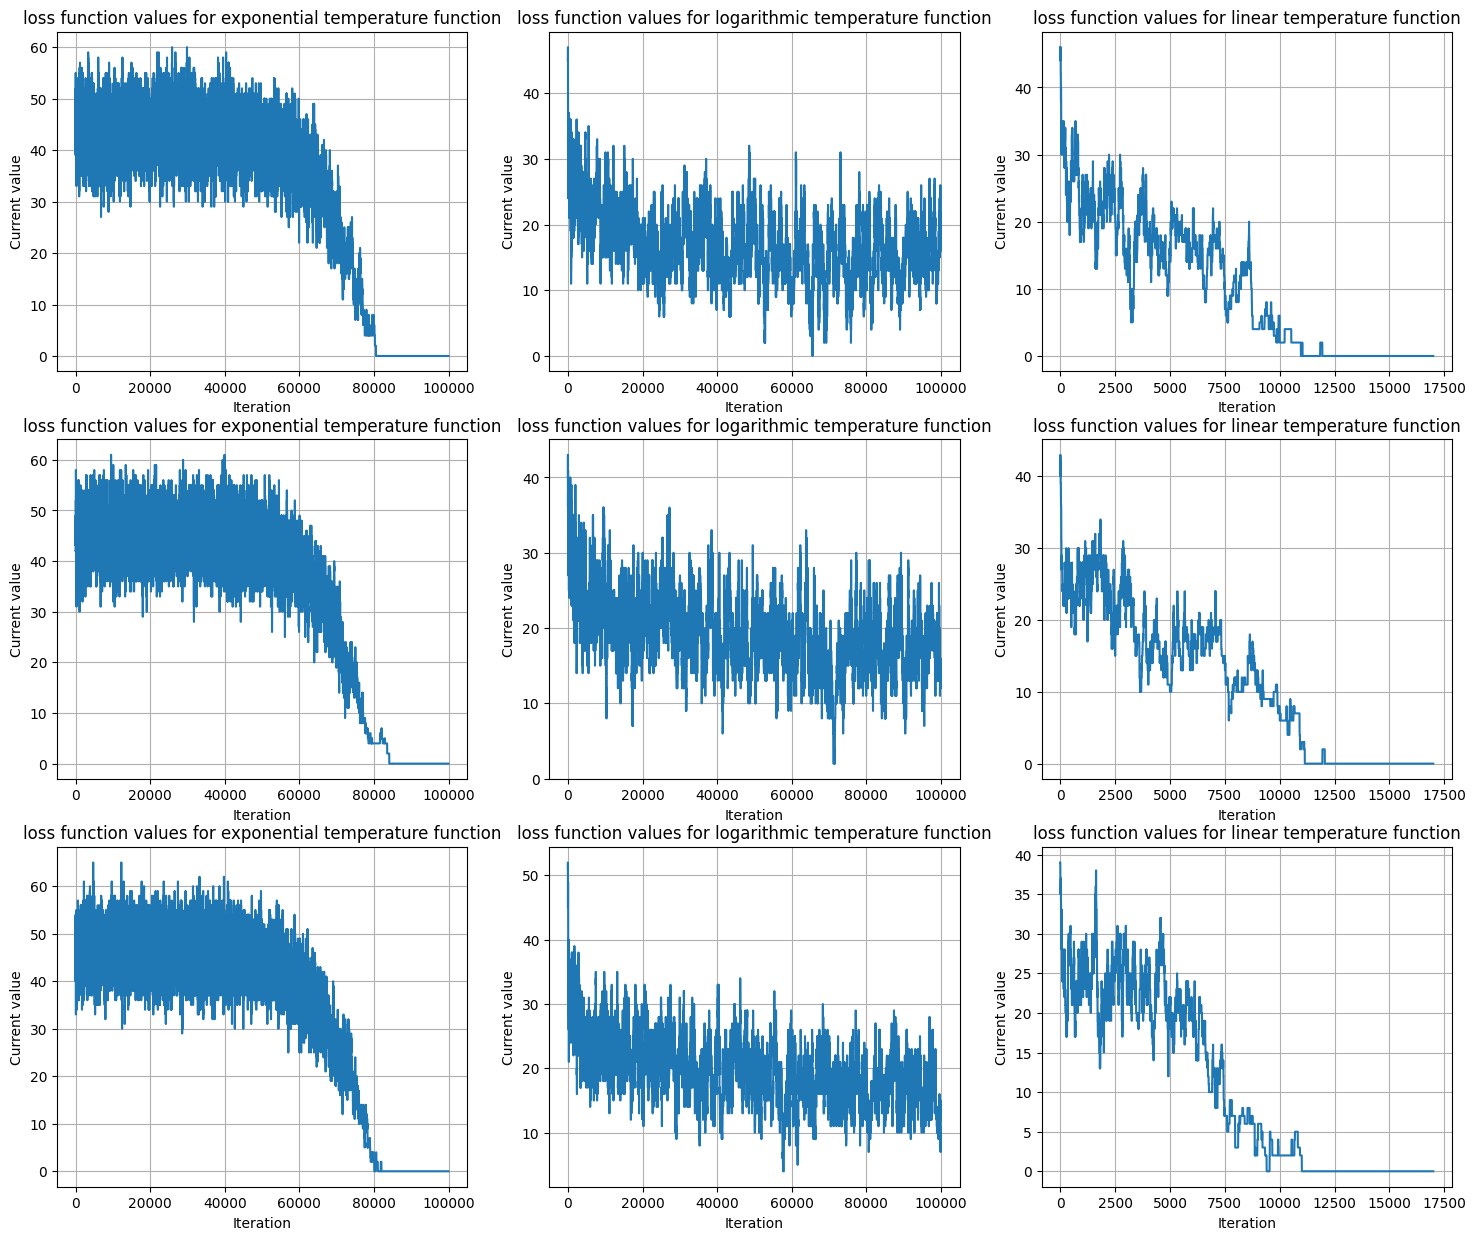

In [138]:
_, ax = plt.subplots(len(final_results), 3, figsize=(18,5 * len(final_results)))
for i, results in enumerate(final_results):
    draw_plot(results[0][1], ax[i][0], title="loss function values for exponential temperature function")
    draw_plot(results[1][1], ax[i][1], title="loss function values for logarithmic temperature function")
    draw_plot(results[2][1], ax[i][2], title="loss function values for linear temperature function")